In [1]:
from __future__ import print_function, division
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
# from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import sys
import os
import scipy
import cv2
from skimage import data
# from imageio import imread
import imageio
print(os.listdir("/kaggle/input/pix2pix-dataset"))

def load_data(dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('/kaggle/input/pix2pix-dataset/%s/%s/%s/*' % (dataset_name,dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)
        img_res=(128,128)
        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.
            if (dataset_name=="edges2shoes" or dataset_name=="maps"):
                img_A, img_B = img[:, _w:, :],img[:, :_w, :] 
            else:  
                img_A, img_B = img[:, :_w, :], img[:, _w:, :]
            # decreasing the resolution 
            img_A = transform.resize(img_A, img_res)  #Ground Truth image
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)
            
        
        imgs_A = np.array(imgs_A)/127.5 - 1.  #normalizing the images
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

['edges2shoes', 'cityscapes', 'maps', 'facades']


In [2]:
def load_batch( dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('/kaggle/input/pix2pix-dataset/%s/%s/%s/*' % (dataset_name,dataset_name, data_type))

        
        n_batches=batch_size
        img_res=(128,128)
        for i in range(n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                # because in the edges2shoes and maps dataset the input image comes before the ground truth.
                if (dataset_name=="edges2shoes"or dataset_name=="maps"):
                      img_A, img_B = img[:, half_w:, :],img[:, :half_w, :] 
                else:  
                      img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
                
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)
            # normalizing the images 
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B
def imread(path):
        return imageio.imread(path, pilmode='RGB').astype(np.float)

In [3]:
# Input shape
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

gf = 64
df = 64
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input]) #skip connection
            return u

        
        d0 = Input(shape=img_shape)

        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, gf*8)
        u2 = deconv2d(u1, d5, gf*8)
        u3 = deconv2d(u2, d4, gf*8)
        u4 = deconv2d(u3, d3, gf*4)
        u5 = deconv2d(u4, d2, gf*2)
        u6 = deconv2d(u5, d1, gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

In [4]:
build_generator().summary()

2023-02-01 01:57:20.820888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 01:57:20.977195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 01:57:20.978243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 01:57:20.980116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [5]:
def build_discriminator():
        # a small function to make one layer of the discriminator
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=img_shape)
        img_B = Input(shape=img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

In [6]:
build_discriminator().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 128, 128, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 64)   6208        concatenate_6[0][0]        

In [7]:



# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D


optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)


In [8]:
def show_images( dataset_name,epoch, batch_i):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(dataset_name,batch_size=3, is_val=True)
        fake_A = generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [9]:
import wandb

In [10]:
with open('/root/.netrc', 'w', encoding='utf-8') as f:
    f.write('''machine api.wandb.ai
        login user
        password 84ad0bc595afaa0b055aad3fb3c10ebc02f48f29
    ''')

In [11]:
#  wandb.init(project="Image to image", name = 'model_cgan_cityscapes')

In [12]:
def train( dataset_name,epochs, batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            d_loss = 0.0
            g_loss = 0.0
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name,batch_size)):

                
                #  Train Discriminator
                

                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            if epoch%10==0:
                  print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[1],
                                                                        elapsed_time))
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(dataset_name,epoch, batch_i)
            wandb.log({
                        "epoch": epoch,
                        "train_d_loss": d_loss[0],
                        "train_g_loss": g_loss[1],
                    })
            

In [13]:
 wandb.init(project="Image to image", name = 'model_cgan_cityscapes')

wandb: Currently logged in as: hienthai. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
2023-02-01 01:57:34.860819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-01 01:57:36.169308: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN

[Epoch 0/100]  [D loss: 0.485091, acc:  49%] [G loss: 0.488974] time: 0:01:01.390838


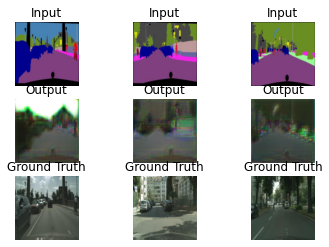

[Epoch 10/100]  [D loss: 0.150418, acc:  89%] [G loss: 0.396414] time: 0:06:09.604677


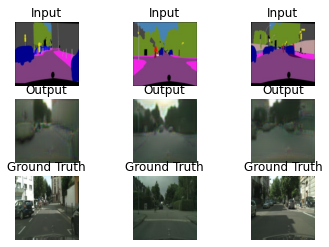

[Epoch 20/100]  [D loss: 0.097437, acc:  92%] [G loss: 0.401427] time: 0:11:14.227586


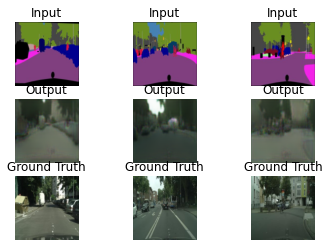

[Epoch 30/100]  [D loss: 0.018617, acc:  99%] [G loss: 0.279849] time: 0:16:16.303962


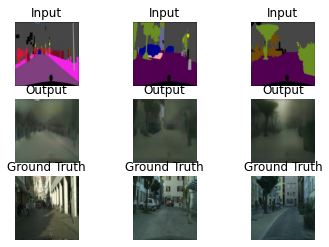

[Epoch 40/100]  [D loss: 0.015450, acc:  99%] [G loss: 0.227495] time: 0:21:19.806002


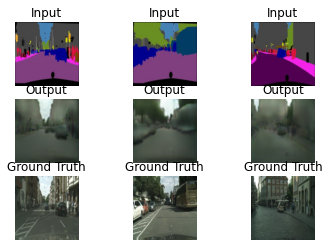

[Epoch 50/100]  [D loss: 0.019285, acc:  99%] [G loss: 0.278266] time: 0:26:21.311275


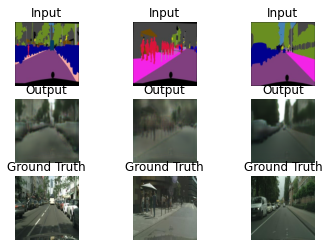

[Epoch 60/100]  [D loss: 0.034115, acc:  98%] [G loss: 0.322988] time: 0:31:26.318681


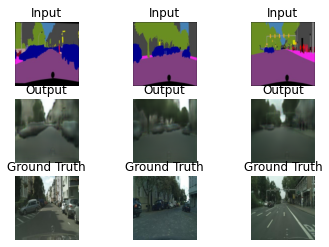

[Epoch 70/100]  [D loss: 0.008015, acc: 100%] [G loss: 0.204014] time: 0:36:32.898275


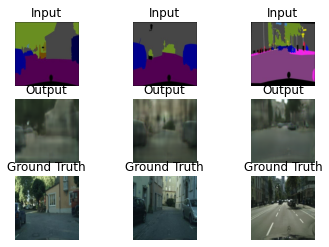

[Epoch 80/100]  [D loss: 0.007154, acc: 100%] [G loss: 0.195174] time: 0:41:33.891846


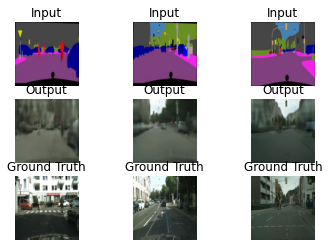

[Epoch 90/100]  [D loss: 0.004433, acc: 100%] [G loss: 0.203857] time: 0:46:34.180491


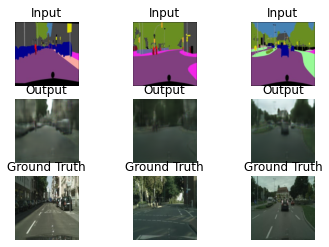

In [14]:
train("cityscapes",epochs=100, batch_size=32, show_interval=10)

In [15]:
 wandb.init(project="Image to image", name = 'model_cgan_edges2shoes')


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_d_loss,█▅▃▂▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_g_loss,▅█▃▁▄▁▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▁▂▂▁▂▂▁▁▁▁▁▂▂
epoch,99
train_d_loss,0.00827
train_g_loss,0.22963


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[Epoch 0/100]  [D loss: 0.053056, acc:  96%] [G loss: 0.461038] time: 0:00:50.687441


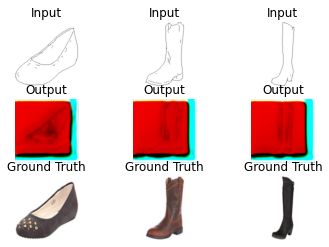

[Epoch 10/100]  [D loss: 0.026649, acc:  99%] [G loss: 0.469009] time: 0:05:57.014480


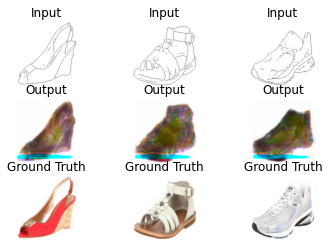

[Epoch 20/100]  [D loss: 0.015845, acc:  99%] [G loss: 0.359239] time: 0:10:58.408920


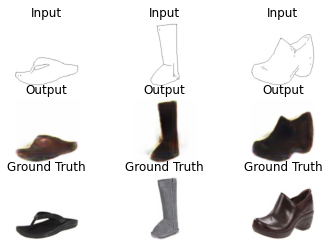

[Epoch 30/100]  [D loss: 0.004982, acc: 100%] [G loss: 0.317056] time: 0:16:03.987700


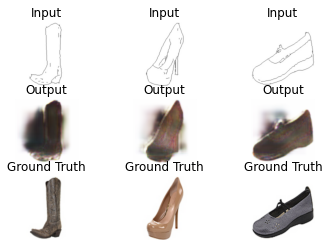

[Epoch 40/100]  [D loss: 0.009802, acc: 100%] [G loss: 0.337106] time: 0:21:07.509097


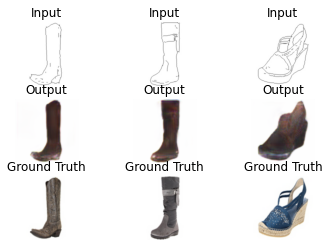

[Epoch 50/100]  [D loss: 0.006309, acc:  99%] [G loss: 0.326808] time: 0:26:11.845775


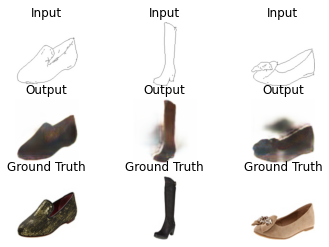

[Epoch 60/100]  [D loss: 0.017757, acc: 100%] [G loss: 0.388132] time: 0:31:16.571897


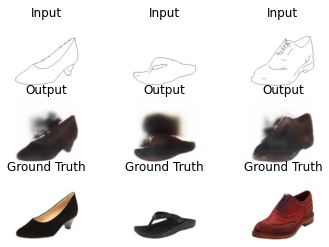

[Epoch 70/100]  [D loss: 0.013057, acc: 100%] [G loss: 0.435087] time: 0:36:19.312623


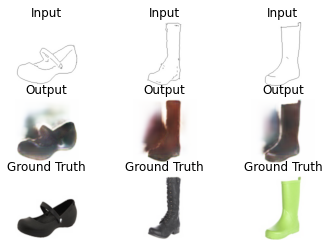

[Epoch 80/100]  [D loss: 0.012312, acc: 100%] [G loss: 0.395077] time: 0:41:21.384594


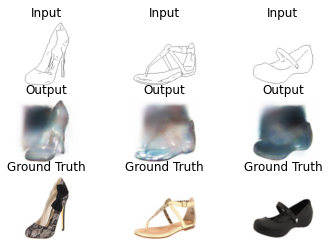

[Epoch 90/100]  [D loss: 0.009577, acc: 100%] [G loss: 0.429758] time: 0:46:24.014278


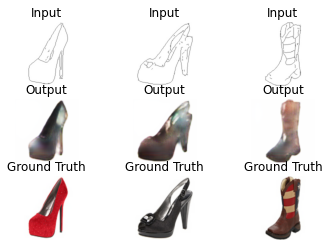

In [16]:
train("edges2shoes",epochs=100, batch_size=32, show_interval=10)

In [17]:
 wandb.init(project="Image to image", name = 'model_cgan_maps')


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_d_loss,▄▄▃▁▂▂▄▃▂▂▁▁▁▂▃▂▁▁▂▃▁▂▃▂▂▂▄▁▂▁▁▂▁▂▁▂▁▁█▁
train_g_loss,▆▆█▅▆▄▇▄▂▂▂▃▁▃▂▃▂▂▅▃▁▂▁▅▃▃▇▅▃▆▆█▄▇▆▅▅▅█▃
epoch,99
train_d_loss,0.00922
train_g_loss,0.37002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[Epoch 0/100]  [D loss: 0.194577, acc:  78%] [G loss: 0.267980] time: 0:01:37.155377


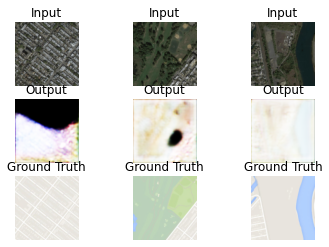

[Epoch 10/100]  [D loss: 0.011076, acc: 100%] [G loss: 0.547986] time: 0:14:05.842481


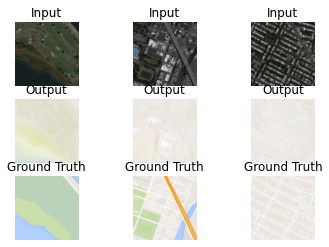

[Epoch 20/100]  [D loss: 0.003449, acc: 100%] [G loss: 0.527655] time: 0:26:28.659304


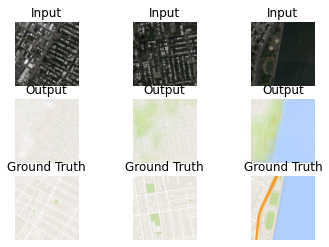

[Epoch 30/100]  [D loss: 0.006681, acc: 100%] [G loss: 0.503557] time: 0:39:19.527321


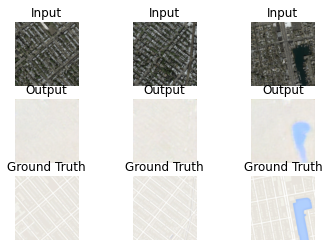

[Epoch 40/100]  [D loss: 0.005423, acc: 100%] [G loss: 0.519203] time: 0:51:46.602005


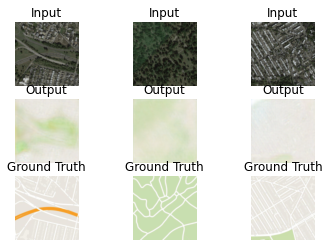

[Epoch 50/100]  [D loss: 0.002988, acc: 100%] [G loss: 0.501765] time: 1:04:15.916313


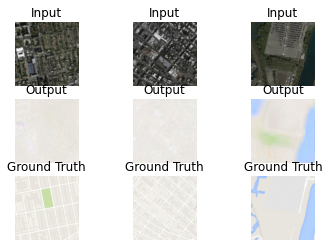

[Epoch 60/100]  [D loss: 0.007741, acc: 100%] [G loss: 0.566168] time: 1:16:33.259180


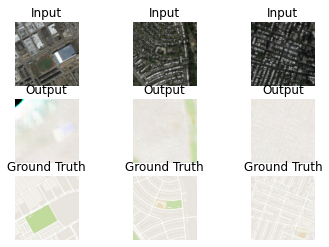

[Epoch 70/100]  [D loss: 0.054319, acc:  92%] [G loss: 0.779672] time: 1:28:57.377955


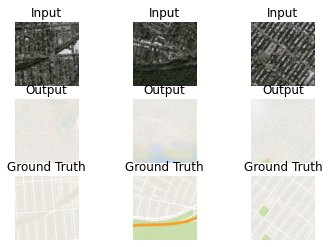

[Epoch 80/100]  [D loss: 0.003201, acc: 100%] [G loss: 0.648251] time: 1:41:22.209321


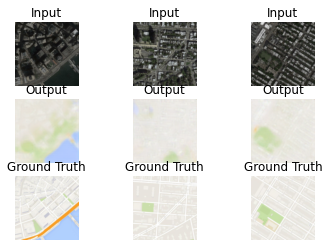

[Epoch 90/100]  [D loss: 0.002132, acc: 100%] [G loss: 0.618526] time: 1:53:47.729401


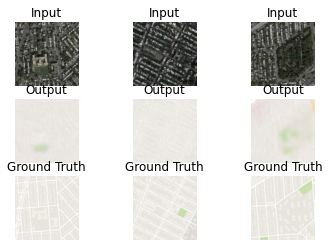

In [18]:
train("maps",epochs=100, batch_size=32, show_interval=10)